# Based on 'A  Neural Probabilistic Language Model' Bengio et al. 2003

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [314]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [3]:
words = open('DL/NLP/makemore/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# Build the vocab of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [315]:
def build_dataset(words, device=device):
    block_size = 3
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            # print(''.join(itos[i] for i in context), '-->', itos[idx])
            context = context[1:] + [idx]
    return torch.tensor(X).to(device), torch.tensor(Y).to(device)

train_len = int(0.8 * len(words))
val_len = int(0.1 * len(words))

X_train, Y_train = build_dataset(words[:train_len])
X_val, Y_val = build_dataset(words[train_len:train_len+val_len])
X_test, Y_test = build_dataset(words[train_len+val_len:])


In [316]:
def init_params(device=device):
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27, 10), generator=g).to(device)
    W1 = torch.randn((30, 200), generator=g).to(device)
    b1 = torch.randn((200), generator=g).to(device)
    W2 = torch.randn((200, 27), generator=g).to(device)
    b2 = torch.randn((27), generator=g).to(device)
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
    return parameters

In [299]:
# Comparing LRs
lrs = 10**torch.linspace(-3, 0, 100).detach().numpy()
# lrs
# lrses = []
losses = []

for i in range(len(lrs)):
    C, W1, b1, W2, b2 = init_params()
    parameters = [C, W1, b1, W2, b2]

    for epoch in range(1000):
        # forward pass
        minibatch = torch.randint(0, X_train.shape[0], (32,)).to(device)
        emb = C[X_train[minibatch]].reshape(len(minibatch), -1)
        x = emb.clone()
        h = torch.tanh(x @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_train[minibatch])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        for p in parameters: 
            p.data += -lrs[i] * p.grad
    # print(f"lr: {lrs[i]} - loss: {loss}")
    # lrses.append(lrs[i])
    losses.append(loss.item())

KeyboardInterrupt: 

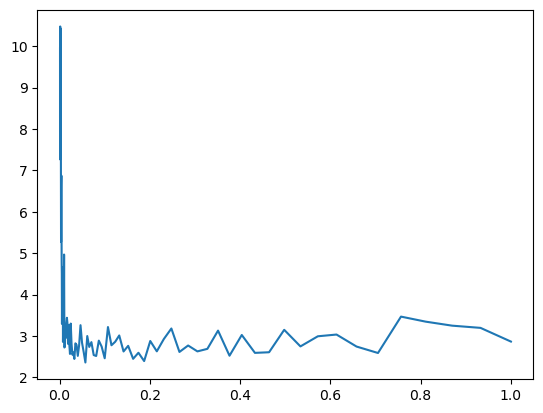

In [142]:
plt.plot(lrs, losses)

In [359]:
C, W1, b1, W2, b2 = init_params()
parameters = [C, W1, b1, W2, b2]
train_lossi = []
val_lossi = []
stepi = []
evali = []

In [360]:
def eval(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view(X.shape[0], -1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss


def train(lr=0.01, epochs = 200000, batch_size=32, step=0, eval_every=1000):
    for epoch in range(epochs):
        # forward pass
        minibatch = torch.randint(0, X_train.shape[0], (batch_size,)).to(device)
        emb = C[X_train[minibatch]].reshape(len(minibatch), -1)
        x = emb.clone()
        h = torch.tanh(x @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_train[minibatch])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        if epochs > 100000:
            lr = lr/10.0
        for p in parameters: 
            p.data += -0.01 * p.grad

        if epoch % eval_every == 0:
            val_loss = eval(X_val, Y_val)
            evali.append(step+epoch)
            val_lossi.append(val_loss.log10().item())

        stepi.append(step+epoch)
        train_lossi.append(loss.log10().item())
    return loss.item()

last train loss: 0.3070077896118164


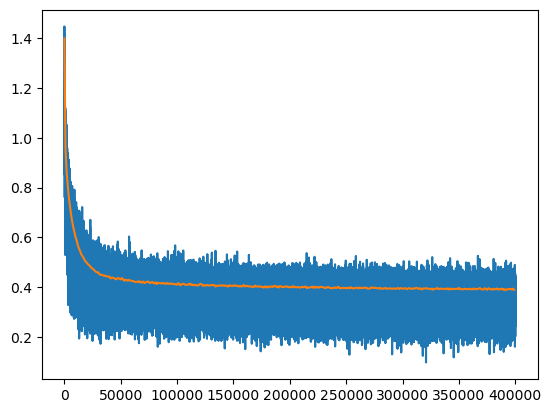

In [364]:
step = stepi[-1] if len(stepi) > 0 else 0
train(lr=0.1, epochs=200000, batch_size=32, step=step)
plt.plot(stepi, train_lossi)
plt.plot(evali, val_lossi)
print(f"last train loss: {train_lossi[-1]}")

In [365]:
print(f"train loss: {eval(X_train, Y_train)}")
print(f"val loss: {eval(X_val, Y_val)}")

train loss: 2.168869733810425
val loss: 2.440819263458252


In [289]:

emb = C[X_val]
h = torch.tanh(emb.view(X_val.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
loss
print(f"val loss: {loss.item()}")

train loss: 2.5021145343780518
val loss: 2.5021145343780518


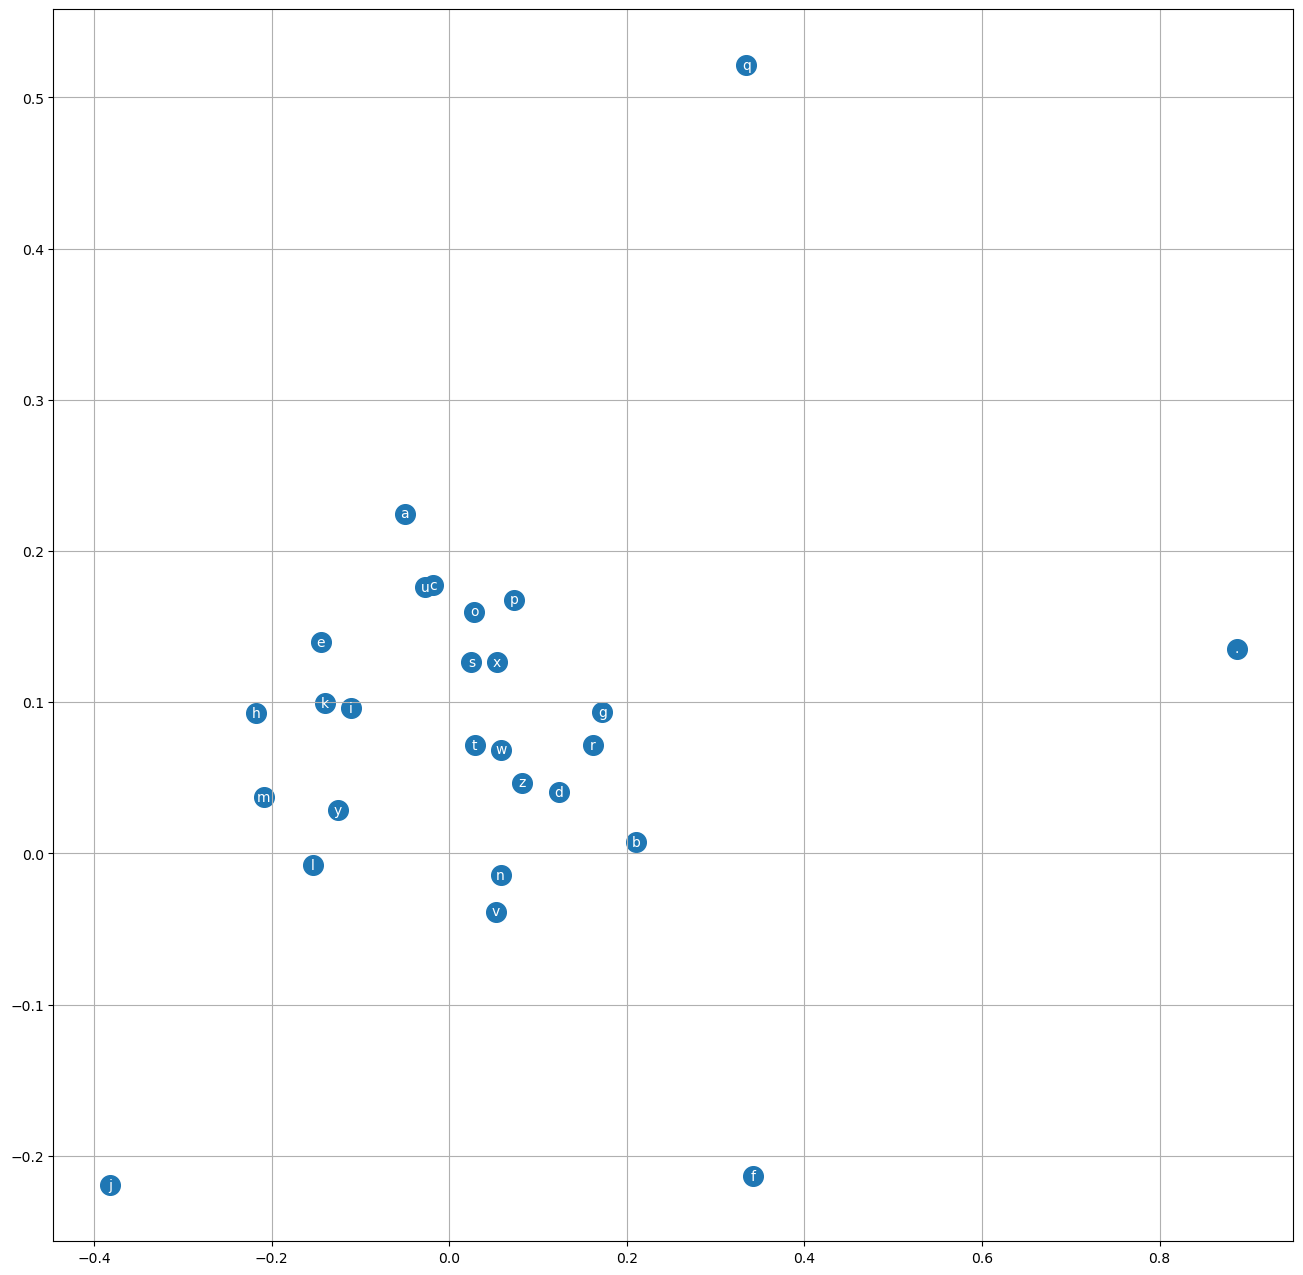

In [290]:
plt.figure(figsize=(16,16))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [291]:
# Sampling from the model

g = torch.Generator().manual_seed(42)

for _ in range (20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    print(''.join(itos[i] for i in out))

anuserovt.
shaabi.
nedyn.
shan.
silaylen.
kemah.
lamin.
epince.
den.
dizi.
kench.
jordon.
kalla.
marieyna.
ahvisia.
ana.
lamitharleigel.
mar.
tal.
jena.
